# Sentiment Analysis With Python and Keras


This notebook demonstrates tutorial processes how to build **binary** text classification models using Python and Keras. First, we train a baseline ML model, and then build neural networks using Keras. After that, we implemented the **embedding** and **maxpooling** layers as well as convolutional neural networks in the Keras models. 

Second part demonstrates using t-SNE to visualize the word embeddings in 2D.  

Third part shows how to load pretrained word embeddings from larger corpus (e.g. **GloVe**) and integrate it in the models. We can directly use the word embeddings to train a classification model, or even allow to retrain the word embeddings during training classification model.


The majority of the content and codes in this notebook follows the blog: [Practical Text Classification With Python and Keras](https://realpython.com/python-keras-text-classification/) by Nikolai Janakiev.

The content:

0. Data Preprocessing
  * 0.A Text preprocessing - CountVectorizer
  * 0.B Text preprocessing - TF-IDF
  * 0.C Text preprocessing - Word Embedding
  * 0.D Categorical Variable Encoder
1. Dataset
2. Sentiment Analysis Model
  * 2.A Baseline
  * 2.B Neural networks in Keras model
  * 2.C Keras Model $-$ Embedding
  * 2.D Keras Model $-$ Embedding + MaxPooling 
  * 2.E Keras Model $-$ Embedding + Convolutional Neural Networks
3. Visualize Word Embeddings in 2D using t-SNE
4. Using Pretrained Word Embeddings
  * 4.A Keras Model $-$ Use Precomputed Word Embedding
  * 4.B Keras Model $-$ Train Precomputed Word Embedding
5. Hyperparameter Optimization



### Reference

* Nikolai Janakiev, [Practical Text Classification With Python and Keras](https://realpython.com/python-keras-text-classification/)

* Jason Brownlee, [How to Use Word Embedding Layers for Deep Learning with Keras](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

* Usman Malik, [Python for NLP: Word Embeddings for Deep Learning in Keras](https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras/)

* Javaid Nabi, [Machine Learning — Word Embedding & Sentiment Classification using Keras](https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456)

* Javaid Nabi, [A Basic NLP Tutorial for News Multiclass Categorization](https://medium.com/@armandj.olivares/a-basic-nlp-tutorial-for-news-multiclass-categorization-82afa6d46aa5#:~:text=Introduction,inherent%20properties%20of%20the%20text.)

## 0. Data Preprocessing

In this tutorial, you’ll see how to deal with representing words as vectors which is the common way to use text in neural networks. Before feature engineering the words, we can use the following example code to remove punctuations, step words etc... (from blog: [Text classification using word embeddings and deep learning in python — classifying tweets from twitter](https://medium.com/analytics-vidhya/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81), by Eligijus Bujokas)

In [267]:
import re

def clean_text(
    string: str, 
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=['the', 'a', 'and', 'is', 'be', 'will']) -> str:
    """
    A method to clean text 
    """
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string        

There are several possible ways to represent a word as a vector, such as one-hot encoding, count, TF-IDF and word embeddings. As an example, assume we have sentences:

In [215]:
sentences = ['John likes ice cream', 'John hates chocolate, John.']


### 0.A Text preprocessing -  CountVectorizer

In [205]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [206]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [2, 1, 0, 1, 0, 0]])

### 0.B Text preprocessing - TF-IDF

There are totally 6 words, plus an empty so num_words = 7:

In [216]:
tokenizer = Tokenizer(num_words=7)
tokenizer.fit_on_texts(sentences)
tokenizer.texts_to_matrix(sentences, mode='tfidf')

array([[0.        , 0.51082562, 0.69314718, 0.69314718, 0.69314718,
        0.        , 0.        ],
       [0.        , 0.86490296, 0.        , 0.        , 0.        ,
        0.69314718, 0.69314718]])

In [214]:
tokenizer.get_config()['index_word']

'{"1": "john", "2": "likes", "3": "ice", "4": "cream", "5": "hates", "6": "chocolate"}'

### 0.C Text preprocessing - Word Embedding 

Word Embedding represents words as **dense word vectors** (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.


Note that the word embeddings do **not** understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the **embedding space**.

In the above example, if the dimension of the embedding space = 4, `john` = $(x_1, x_2, x_3, x_4)$, `ice` = $(y_1, y_2, y_3, y_4)$, ...

The embedding captures the relationship between words well. A famous example in this field of study is the ability to map 

`King - Man = Queen - Woman`

First, map each word to index:

In [207]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(sen.split()) for sen in sentences])
print ("vocab_size:", vocab_size, ", max_length:", max_length)

X_tokens = tokenizer.texts_to_sequences(sentences)
padded_sentences = pad_sequences(X_tokens, maxlen=max_length, padding='post')

padded_sentences

vocab_size: 7 , max_length: 4


array([[1, 2, 3, 4],
       [1, 5, 6, 1]], dtype=int32)

In [208]:
tokenizer.get_config()['index_word']

'{"1": "john", "2": "likes", "3": "ice", "4": "cream", "5": "hates", "6": "chocolate"}'

How can you get such a word embedding? You have two options for this. One way is to train your word embeddings during the training of your neural network. The other way is by using pretrained word embeddings which you can directly use in your model. There you have the option to either leave these word embeddings unchanged during training or you train them also.

### 0. D Categorical Variable Encoder

For categorical variable, we encode to integer label using `LabelEncoder`, and then to one-hot-encoding format using `OneHotEncoder`. This step is required if this categorical variable is a target variable and our goal is multiclass classification. 

If there are many types, still prefer the above embedding method.

In [39]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']

####  Label-Encoder

In [40]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

#### One-Hot-Encoder

In [41]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

## 1. Dataset

The data set is from the [Sentiment Labelled Sentences](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) Data Set from the UCI Machine Learning Repository. Three data source: **yelp**, **amazon**, and **imdb**. Given a sentence, we want to predict it is positive or negative.

In this notebook, we only focus on **yelp** reviews.

In [174]:
import pandas as pd

filepath_dict = {'yelp':   'sentiment_analysis/yelp_labelled.txt',
                 'amazon': 'sentiment_analysis/amazon_cells_labelled.txt',
                 'imdb':   'sentiment_analysis/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [175]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [43]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

X = df_yelp['sentence'].tolist()
y = df_yelp['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [44]:
X_train[:2], y_train[:2]

(['The food was barely lukewarm, so it must have been sitting waiting for the server to bring it out to us.',
  'Sorry, I will not be getting food from here anytime soon :('],
 [0, 0])

## 2. Sentiment Analysis Model

### 2.A Baseline 

In [217]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

x_train = vectorizer.transform(X_train)
x_test  = vectorizer.transform(X_test)

In [218]:
x_train.shape

(750, 1714)

In [219]:
x_train[:2]

<2x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 28 stored elements in Compressed Sparse Row format>

There are 1714 words in this corpus. The data convert to sparse matrix format, and we cannot review directly. It turns out to be dictionary format and we can look up by [following way](https://stackoverflow.com/questions/26889597/read-sparse-matrix-in-python):

In [226]:
for i, x in enumerate(x_train.todok().keys()):
    print (x, x_train[x])
    if i >= 5: break

(41, 0) 1
(99, 1) 1
(370, 1) 1
(524, 1) 1
(688, 1) 1
(403, 2) 1


In [231]:
[(x, vectorizer.vocabulary_[x]) for x in vectorizer.vocabulary_][:5]

[('the', 1494),
 ('food', 597),
 ('was', 1634),
 ('barely', 125),
 ('lukewarm', 888)]

In [48]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)
print("Accuracy:", score)

Accuracy: 0.796


### 2.B Neural Networks using Keras

Start to build neural networks using Keras.

* **input layer $\to$ hidden layer**: input_dim = 1714, number of neurons in the hidden layer= 10; Number of paramters = $1714 \times 10 + 10 = 17150$. 

* **hidden layer $\to$ output layer (sigmoid)**: Number of paramters = $10 \times 1 + 1 = 10$.

In [227]:
from keras.models import Sequential
from keras.layers import Dense

input_dim = x_train.shape[1]  # Number of features

print ('input_dim:', input_dim)

model = Sequential()
model.add(Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

input_dim: 1714
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 10)                17150     
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 11        
Total params: 17,161
Trainable params: 17,161
Non-trainable params: 0
_________________________________________________________________


In [228]:
history = model.fit(x_train, y_train, epochs=100, verbose=0, validation_data=(x_test, y_test), batch_size=10)

loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7840


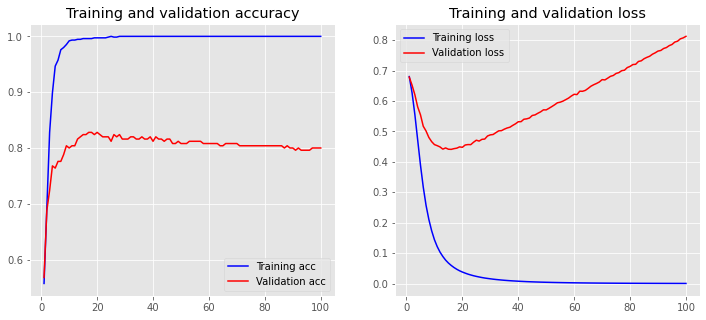

In [53]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

### 2.C Keras Model $-$ Embedding

Now we add embedding layer in the Keras model. Before that, tokenize each sentence to intger index:

In [233]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(sentence.split()) for sentence in X_train])
print ("vocab_size:", vocab_size, ", max_length:", max_length)

x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')

x_train[:2]

vocab_size: 1747 , max_length: 32


array([[  1,  10,   3, 282, 739,  25,   8, 208,  30,  64, 459, 230,  13,
          1, 124,   5, 231,   8,  58,   5,  67,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [740,   4,  46,  12,  20, 160,  10,  72,  35, 355, 232,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]], dtype=int32)

In [245]:
index_word_dict = tokenizer.index_word
[(i, index_word_dict[i]) for i in range(1, 10)]

[(1, 'the'),
 (2, 'and'),
 (3, 'was'),
 (4, 'i'),
 (5, 'to'),
 (6, 'a'),
 (7, 'is'),
 (8, 'it'),
 (9, 'this')]

We will show how to get and visualize the word embeddings in later section: **Visualize Word Embeddings in 2D using t-SNE**. Next let's focus on training models.

Assume embedding_dim = 20, and we let input dim = 32. Now the Keras model architecure becomes: 

`embedding -> flatten -> input -> hidden -> output`

* **embedding layer**: vocab_size = 1747, dim in the embedding layer= 20; paramters in embedding layer = $1747 \times 20 = 34940$. 

* **flatten layer**: embedding_dim= 20, input_dim = 32; parameters in flatten layer = $32 \times 20 = 640$ (NOTE, now input_dim is reduced from 1714 using `CounterVectorizer`).

* **input layer $\to$ hidden layer**: input_dim = 640, num of neurons in the hidden layer = 10; paramters = $640 \times 10 + 10 = 6410$. 

* **hidden layer $\to$ output layer**: Number of paramters = $10 \times 1 + 1 = 11$.

In [62]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 20

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 32, 20)            34940     
_________________________________________________________________
flatten_4 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                6410      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 41,361
Trainable params: 41,361
Non-trainable params: 0
_________________________________________________________________


/Users/hsianghsuanhung/opt/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.7400


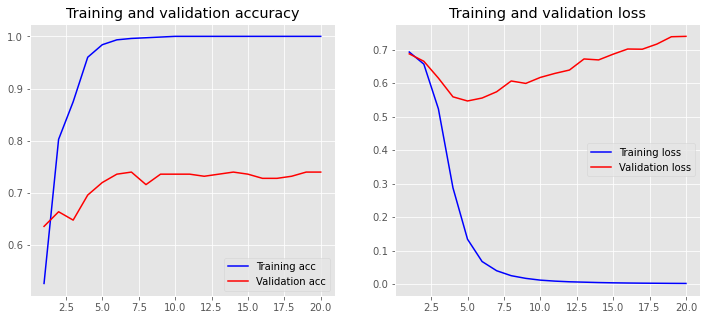

In [64]:
history = model.fit(x_train, y_train, epochs=20, verbose=False, validation_data=(x_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### 2.D Keras Model $-$ Embedding + MaxPooling

Next let's work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to downsample (a way to reduce the size of) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

In [262]:
from keras.layers import GlobalMaxPool1D

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 32, 20)            34940     
_________________________________________________________________
global_max_pooling1d_35 (Glo (None, 20)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 11        
Total params: 35,161
Trainable params: 35,161
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7840


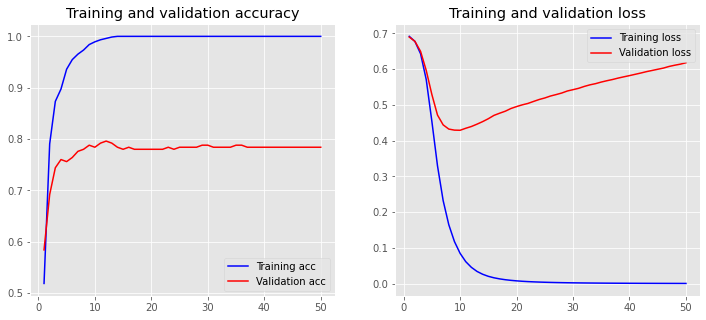

In [247]:
history = model.fit(x_train, y_train, epochs=50, verbose=False, validation_data=(x_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

We can see the `GlobalMaxPool1D` layer is really helpful.

### 2.E Keras Model $-$  Embedding + Convolutional Neural Networks (CNN)

CNN is used in image processing makes them also handy for sequence processing. You can imagine a CNN as a specialized neural network that is able to detect specific patterns.

A CNN has so-called `convolutional` layers in hidden layers. The convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

In [263]:
from keras.layers import Conv1D, GlobalMaxPooling1D

embedding_dim = 20

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 32, 20)            34940     
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 28, 128)           12928     
_________________________________________________________________
global_max_pooling1d_36 (Glo (None, 128)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 11        
Total params: 49,169
Trainable params: 49,169
Non-trainable params: 0
_________________________________________________________________


/Users/hsianghsuanhung/opt/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training Accuracy: 1.0000
Testing Accuracy:  0.7960


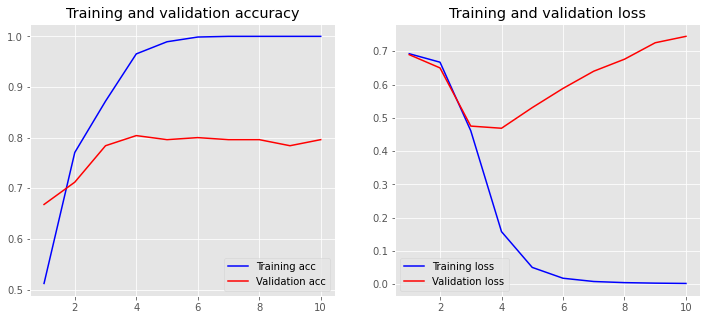

In [264]:
history = model.fit(x_train, y_train, epochs=10, verbose=False, validation_data=(x_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## 3. Visualize Word Embeddings in 2D using t-SNE

Now we embed each word from index to a 20-dimensional vector. To get word embeddings:

In [252]:
weights = model.layers[0].get_weights()[0]

In [92]:
weights.shape

(1747, 20)

In [109]:
weights[:2]

array([[ 0.14179447, -0.05761727, -0.07114179,  0.0851886 , -0.05841638,
        -0.03745078,  0.08474775, -0.0897455 , -0.05579542, -0.07916023,
        -0.06470054,  0.09479059, -0.06953621,  0.0906327 , -0.12707846,
        -0.07294843,  0.06461649,  0.13663061, -0.04323901,  0.12661473],
       [-0.05369995, -0.00238331,  0.00931039,  0.01889792,  0.03660279,
        -0.03045067, -0.01781353,  0.00676926, -0.08470508,  0.05553355,
        -0.00267805,  0.06225317, -0.07306585,  0.0043536 , -0.0228148 ,
        -0.01115544,  0.05366289, -0.03994158, -0.08943195,  0.00107007]],
      dtype=float32)

In [253]:
embeddings = pd.DataFrame(weights)

In [254]:
embeddings.shape

(1747, 20)

In [113]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.141794,-0.057617,-0.071142,0.085189,-0.058416,-0.037451,0.084748,-0.089745,-0.055795,-0.079160,-0.064701,0.094791,-0.069536,0.090633,-0.127078,-0.072948,0.064616,0.136631,-0.043239,0.126615
1,-0.053700,-0.002383,0.009310,0.018898,0.036603,-0.030451,-0.017814,0.006769,-0.084705,0.055534,-0.002678,0.062253,-0.073066,0.004354,-0.022815,-0.011155,0.053663,-0.039942,-0.089432,0.001070
2,-0.013790,0.005248,0.064143,0.061008,-0.039805,-0.103394,0.032069,0.022105,-0.044454,0.007457,-0.027010,0.045794,-0.058605,0.069565,0.005662,0.022029,0.172829,0.035825,-0.138918,0.043240
3,-0.051305,-0.002579,-0.034678,-0.005420,-0.052189,0.029490,0.004654,-0.000985,0.066017,0.017506,-0.056457,0.013187,0.059899,0.043743,0.008541,-0.043133,0.008146,-0.029089,0.020773,-0.008960
4,-0.046158,0.134689,-0.072143,0.016522,-0.078571,0.023699,-0.044455,-0.109601,0.076457,-0.016372,-0.028826,-0.015099,-0.018080,0.102500,0.031121,-0.070536,-0.088852,-0.056402,-0.048062,-0.012374


Note that the there are 1747 words in embeddings including **empty string** (first row). So the real correspoding index started from 1 to 1746. Each row reprsents a word. We can use the following way to get mapping index $\to$ word or word $\to$ index:

In [250]:
word_index_dict = tokenizer.word_index
index_word_dict = tokenizer.index_word

In [256]:
len(index_word_dict), len(word_index_dict)

(1746, 1746)

Then map the 20-dimensional embedding space to 2D:

In [255]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2)
tsne_embedded = tsne.fit_transform(embeddings)

In [139]:
tsne_embedded.shape

(1747, 2)

Let's focus some representative words from the yelp corpus:

In [257]:
goods = ['good', 'awesome', 'amazing', 'delicious', 'fresh', 'fantastic', 'perfect', 'clean', 'recommend', 'excellent', 'impressed', 'yummy']
bads = ['disappointed', 'buffet', 'sandwich', 'terrible', 'worst', 'poor', 'seafood', 'rice', 'disappointing', 'shrimp']
foods = ['chicken', 'chicken', 'salad', 'burger', 'sushi', 'fries', 'chips', 'salmon', 'rice', 'beer']
example_words = set(goods + bads + foods)

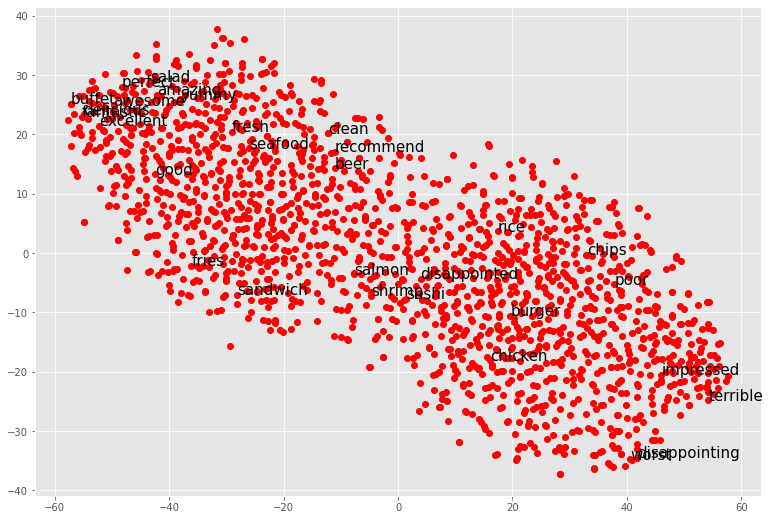

In [258]:
fig = plt.subplots(figsize=(13, 9))

i = 1
for x, y in zip(tsne_embedded[1:, 0], tsne_embedded[1:, 1]):
    if index_word_dict[i] in example_words:
        type_name = index_word_dict[i]
        plt.plot(x, y, 'ro')
        plt.text(x, y, '%s' % (type_name), size=15)
    else:
        plt.plot(x, y, 'ro')

    i += 1
    

plt.show()

We can see salmon is nearby shrimp, fries neabry sandwich...

## 4. Using Pretrained Word Embeddings


Above is an example of learning word embeddings incorporated into the classification problem that we want to solve. 

An alternative is to use a **pretrained** embedding space that utilizes a much **larger corpus**. It is possible to precompute word embeddings by simply training them on a large corpus of text. There are mainly two approaches: **Word2Vec** and **GloVe**.

[Word2Vec](https://code.google.com/archive/p/word2vec/) achieves this by employing neural networks and GloVe achieves this with a co-occurrence matrix and by using matrix factorization. In both cases you are dealing with dimensionality reduction, but Word2Vec is more accurate and GloVe is faster to compute.


### GloVe

In the following, we still follow the blog: [Practical Text Classification With Python and Keras](https://realpython.com/python-keras-text-classification/) using [GloVe](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation) developed by the Stanford NLP Group for pretrained method, and then retrain the binary classification problem.

There are 400000 lines in the GloVe file. We can use the word embeddings and retrain models. Each line in the file starts with the word and is followed by the embedding vector for the particular word. For example, first line of the `glove.6B.50d.txt` shows

`the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.04445`

In our classification problem, we can only focus on the words that we have in our vocabulary, no need use all lines.


In [176]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [196]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B/glove.6B.50d.txt', 
                                               tokenizer.word_index, embedding_dim)

Next we can see how many word embeddings in the pretrained model cover our vocabulary here:

In [193]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9507727532913566

This means 95.1% of the vocabulary is covered by the pretrained model, which is a good coverage of our vocabulary.

### 4.A Keras Model $-$ Use Precomputed Word Embeddings

Now, we directly use the precomputed word embeddings and feed in the machine learning mdoel:

In [197]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 32, 50)            87350     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total params: 87,871
Trainable params: 521
Non-trainable params: 87,350
_________________________________________________________________


Training Accuracy: 0.7520
Testing Accuracy:  0.7000


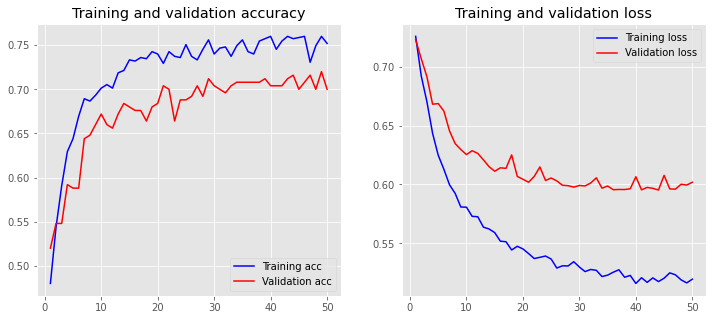

In [198]:
history = model.fit(x_train, y_train, epochs=50, verbose=False, validation_data=(x_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### 4.B Keras Model  $-$  Train Precomputed Word Embeddings

Note in the above Keras model, the word embeddings are **NOT** trained. Therefore we have low accuracy: testing accuracy = 0.7. 

Now let’s now see how this performs if we allow the embedding to be trained by using `trainable=True`:

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 32, 50)            87350     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.7520


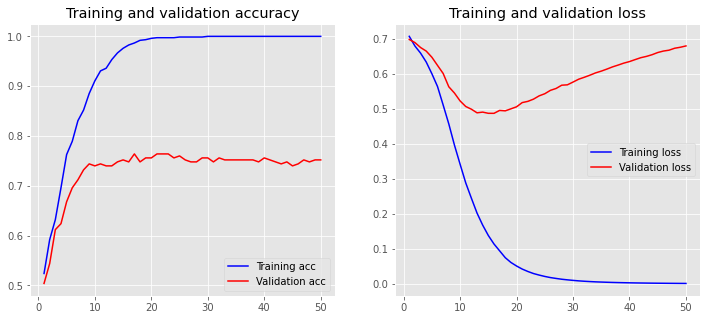

In [199]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, epochs=50, verbose=False, validation_data=(x_test, y_test), batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


Now the word embeddings are re-trained using our data. We can see testing accuracy raises to 0.75. 

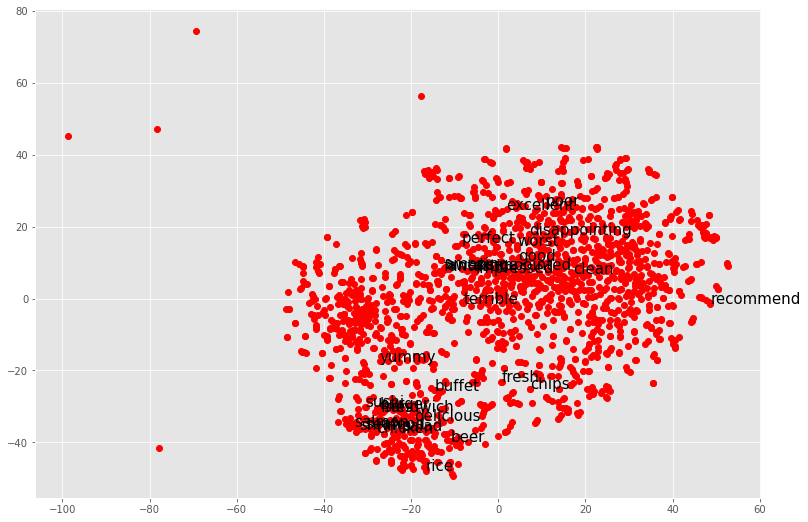

In [200]:
weights = model.layers[0].get_weights()[0]
embeddings = pd.DataFrame(weights)
tsne_embedded = tsne.fit_transform(embeddings)

example_words = set(goods + bads + foods)

fig = plt.subplots(figsize=(13, 9))

i = 1
for x, y in zip(tsne_embedded[1:, 0], tsne_embedded[1:, 1]):
    if index_word_dict[str(i)] in example_words:
        type_name = index_word_dict[str(i)]
        plt.plot(x, y, 'ro')from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

        plt.text(x, y, '%s' % (type_name), size=15)
    else:
        plt.plot(x, y, 'ro')

    i += 1
    

plt.show()

## 5. Hyperparameter Optimization

Finally we move to hyperparameter tuning Keras model. We took the last Keras model, CNN to perform hyperparamter tuning. 

Here we still follow the discussion: [Practical Text Classification With Python and Keras](https://realpython.com/python-keras-text-classification/) and use **random search** for hyperparameter tuning.

Recall in CNN, we have `Conv1D` layer, which can have hyperparameters: `num_filters` and `kernel_size`. The Keras model is defined below:

In [265]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [266]:
vocab_size

1747

We random search hyperparameters as follows:

In [191]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[1747], 
                  embedding_dim=[20],
                  max_length=[32])

In [201]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_model,
                            epochs=50, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(x_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(x_test, y_test)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


/Users/hsianghsuanhung/opt/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/hsianghsuanhung/opt/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/hsianghsuanhung/opt/anaconda3/envs/venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/hsianghsu

In [202]:
test_accuracy 

0.800000011920929

In [203]:
grid_result.best_score_, grid_result.best_params_

(0.7906473875045776,
 {'vocab_size': 1747,
  'num_filters': 32,
  'max_length': 32,
  'kernel_size': 5,
  'embedding_dim': 20})